In [2]:
import librosa
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import warnings

# Turn off all warnings
warnings.filterwarnings('ignore')

In [3]:
def load_and_extract_features(directory_path, sr=22050):
    """
    Load audio files from a directory, extract features, and return them as a numpy array.
    
    Parameters:
    - directory_path: str, path to the directory containing audio files.
    - sr: int, sample rate for audio files. Default is 22050.
    
    Returns:
    - features_data: numpy array, extracted features from all audio files.
    """
    feature_names = ['mfcc', 'chroma', 'mel', 'contrast', 'tonnetz']
    data = np.zeros((0, 174))  # Initialize empty array with correct shape
    
    # Iterate over audio files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            
            # Load audio file
            y, sr = librosa.load(file_path, sr=sr)
            
            # Extract features
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            mel = librosa.feature.melspectrogram(y=y, sr=sr)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            
            # Concatenate features and append to data
            features = np.concatenate([mfcc, chroma, mel, contrast, tonnetz], axis=0).T
            file_name=np.array([filename]*features.shape[0])
            features = np.hstack((features, file_name.reshape(-1, 1)))
            data = np.vstack((data, features))

    data = np.delete(data, 0, axis=0)
    return data

In [4]:
def build_conv_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
    x = MaxPooling1D(2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv1D(16, 3, activation="relu", padding="same")(x)
    x = MaxPooling1D(2, padding="same")(x)
    encoded = BatchNormalization()(x)

    x = Conv1D(16, 3, activation="relu", padding="same")(encoded)
    x = UpSampling1D(2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, 3, activation="relu", padding="same")(x)
    x = UpSampling1D(2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(np.prod(input_shape), activation='relu')(x)
    decoded = Reshape(input_shape)(x)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder, encoder

In [5]:
audio_file_path = "scikit-maad/data"

label_features = load_and_extract_features(audio_file_path)
label_names=label_features[:,-1]
label_names=np.array(pd.DataFrame(label_names).iloc[:,0].str.replace('.wav', ''))
label_features=label_features[:,:-1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(label_features)

features_scaled_reshaped = features_scaled.reshape(-1, features_scaled.shape[1], 1)

input_shape = (features_scaled.shape[1], 1)
autoencoder, encoder = build_conv_autoencoder(input_shape)

autoencoder.fit(features_scaled_reshaped,
                features_scaled_reshaped,
                epochs=50, batch_size=128)

compressed_features = encoder.predict(features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1))
label_compressed_features_flattened = compressed_features.reshape(compressed_features.shape[0], -1)

2024-08-11 12:51:32.788462: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-11 12:51:32.788525: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-11 12:51:32.788548: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-11 12:51:32.788593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 12:51:32.788609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-08-11 12:51:34.381286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 0.8115
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.5024
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.4271
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.4053
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.3877
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.3632
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.3401
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.3398
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.3209
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.3086
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.3000
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.2942
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.2846
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.2768
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss

In [6]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(label_compressed_features_flattened)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(label_compressed_features_flattened)

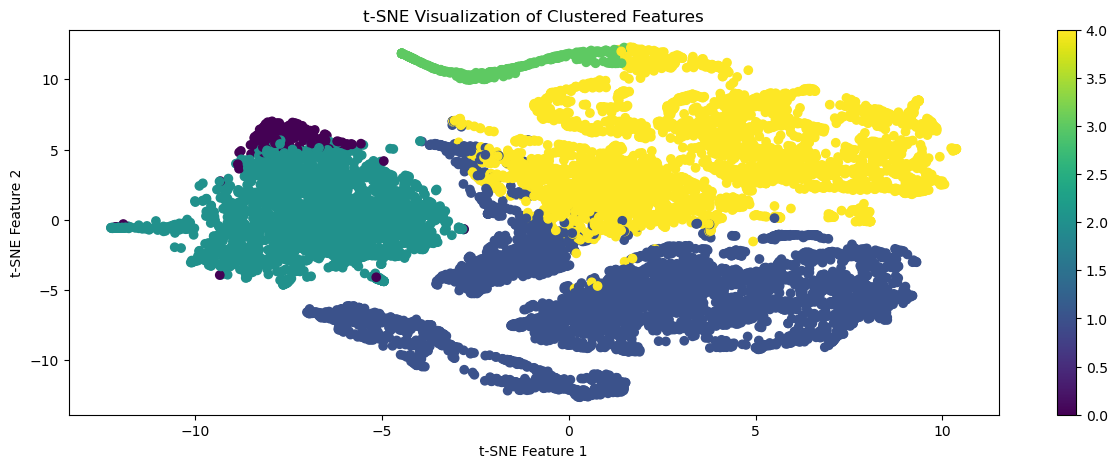

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("t-SNE Visualization of Clustered Features")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.colorbar()
plt.show()

In [8]:
cluster_labels=kmeans.labels_
# Add the cluster labels as an additional feature
X_label = np.hstack((label_compressed_features_flattened, cluster_labels.reshape(-1, 1)))
X_label = np.hstack((X_label, label_names.reshape(-1, 1)))


In [9]:
label_data=pd.DataFrame(X_label)
label_data=label_data.iloc[:,704:]
label_data.columns=['Category','Label_Names']
label_data_groupby=label_data.groupby('Label_Names')['Category'].unique().reset_index()


In [10]:
label_data_groupby['Label_Names'][0]='cold_forest_daylight/tropical_forest_morning'
label_data_groupby=label_data_groupby.iloc[:-1,:]

In [11]:
label_data_groupby

,Label_Names,Category
0,cold_forest_daylight/tropical_forest_morning,"[4.0, 1.0, 2.0]"
1,cold_forest_night,"[4.0, 3.0]"
2,rock_savanna,"[2.0, 0.0]"
3,spinetail,[1.0]


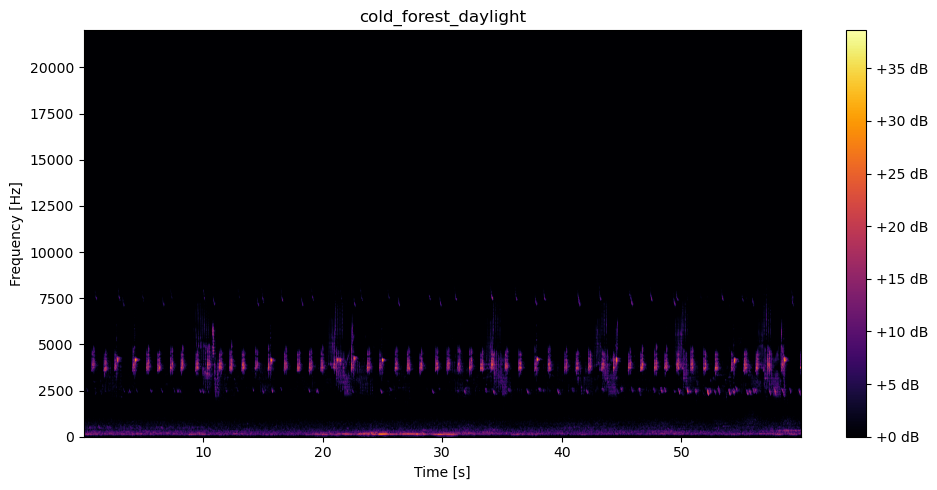

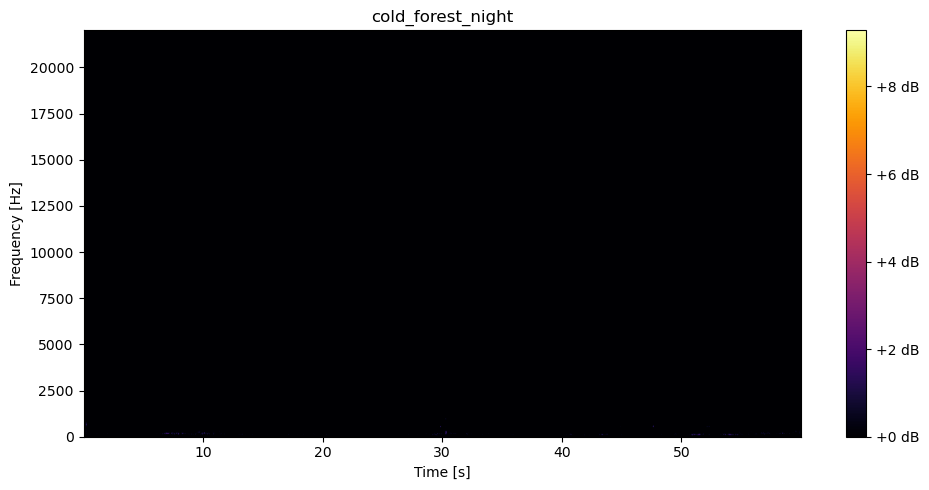

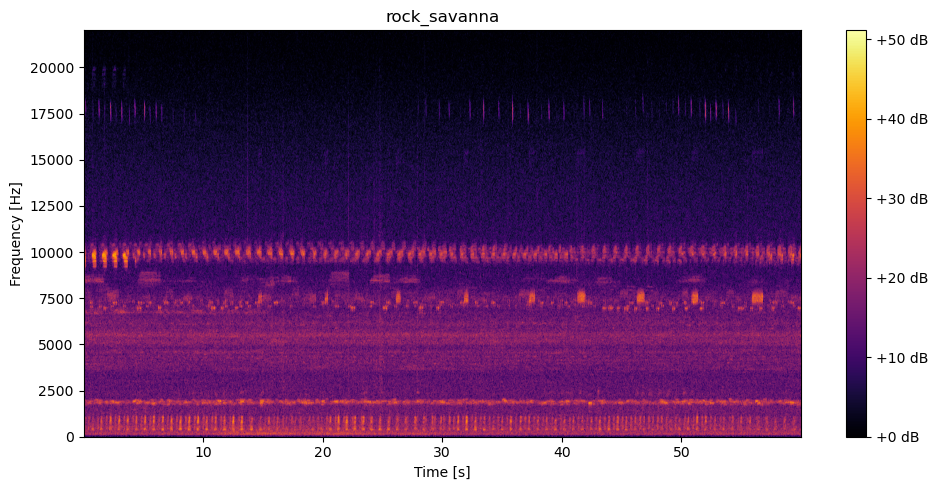

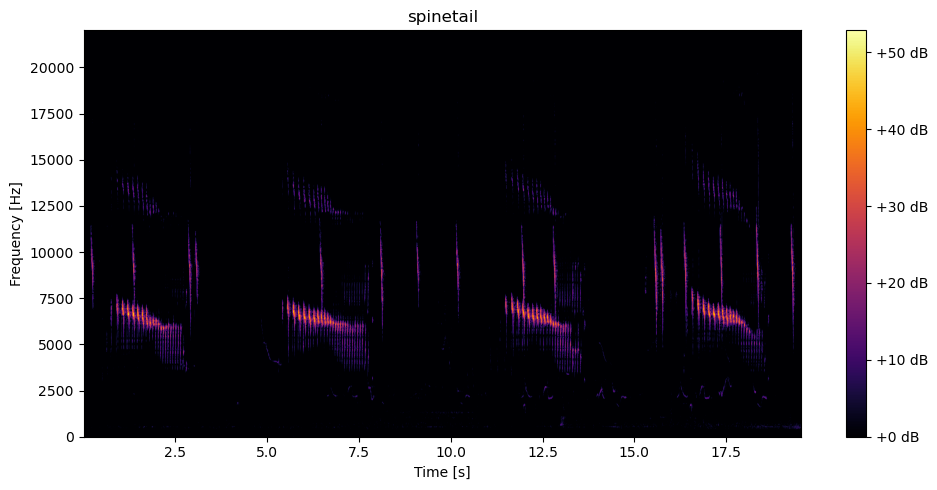

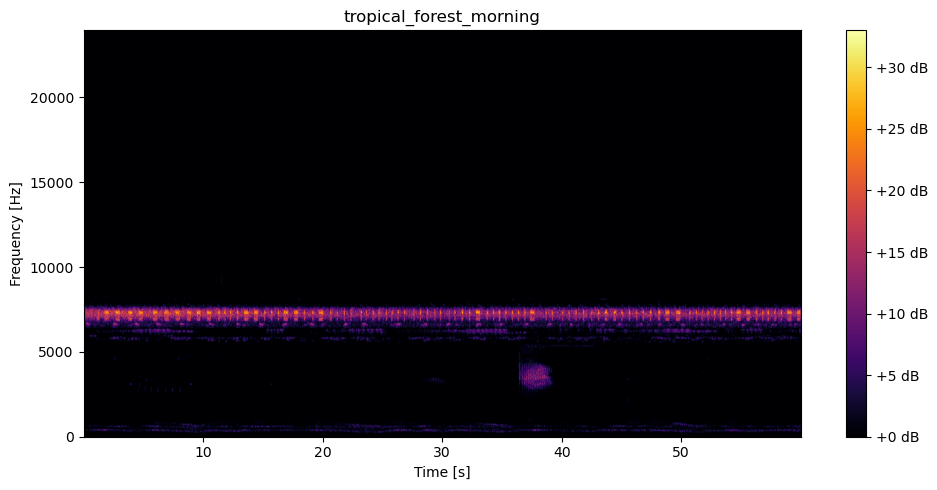

In [10]:
# sphinx_gallery_thumbnail_path = './_images/sphx_glr_plot_unsupervised_sound_classification_004.png'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from maad import sound, features, rois
from maad.util import power2dB, plot2d, format_features, overlay_rois

# List of audio files
audio_files = [
    'scikit-maad/data/cold_forest_daylight.wav',
    'scikit-maad/data/cold_forest_night.wav',
    'scikit-maad/data/rock_savanna.wav', 
    'scikit-maad/data/spinetail.wav', 
    'scikit-maad/data/tropical_forest_morning.wav'  
]
adio_name=['cold_forest_daylight','cold_forest_night','rock_savanna','spinetail','tropical_forest_morning']

# Parameters for processing
fcut = 100
forder = 3
ftype = 'highpass'
db_max = 70

# Loop over each file and plot the spectrogram
for idx, file in enumerate(audio_files):
    # Load the audio file
    s, fs = sound.load(file)
    
    # Apply a high-pass filter to the audio signal
    s_filt = sound.select_bandwidth(s, fs, fcut=fcut, forder=forder, ftype=ftype)
    
    # Compute the spectrogram
    Sxx, tn, fn, ext = sound.spectrogram(s_filt, fs, nperseg=1024, noverlap=512)
    
    # Convert the power spectrogram to decibel scale and normalize
    Sxx_db = power2dB(Sxx, db_range=db_max) + db_max
    
    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.imshow(Sxx_db, extent=ext, aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(format='%+2.0f dB')
    plt.title(adio_name[idx])
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.tight_layout()
    plt.show()


In [11]:
audio_file_path = "scikit-maad/data/indices"

features = load_and_extract_features(audio_file_path)
filenames=features[:,-1]
features=features[:,:-1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled_reshaped = features_scaled.reshape(-1, features_scaled.shape[1], 1)

input_shape = (features_scaled.shape[1], 1)
autoencoder, encoder = build_conv_autoencoder(input_shape)

autoencoder.fit(features_scaled_reshaped,
                features_scaled_reshaped,
                epochs=50, batch_size=128)

compressed_features = encoder.predict(features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1))
compressed_features_flattened = compressed_features.reshape(compressed_features.shape[0], -1)

Epoch 1/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - loss: 0.9171
Epoch 2/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - loss: 0.6654
Epoch 3/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.6431
Epoch 4/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.6230
Epoch 5/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.7116
Epoch 6/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - loss: 0.5954
Epoch 7/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - loss: 0.6589
Epoch 8/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - loss: 0.6047
Epoch 9/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - loss: 0.5856
Epoch 10/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.6125
Epoch 11/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - loss: 0.5721
Epoch 12/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.5726
Epoch 13/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - loss: 0.5296
Epoch 14/50
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - loss: 0.5979
Epoch 15/50
324

In [12]:
predicted_clusters = kmeans.predict(compressed_features_flattened)

In [13]:
# cluster_labels=kmeans.labels_
X=compressed_features_flattened
# Add the cluster labels as an additional feature
X_extended = np.hstack((X, predicted_clusters.reshape(-1, 1)))
X_extended = np.hstack((X_extended, filenames.reshape(-1, 1)))

In [20]:
data=pd.DataFrame(X_extended)

data=data.iloc[:,704:]
data.columns=['Category','File_Names']


In [21]:
data_groupby=data.groupby('File_Names')['Category'].unique().reset_index()
data_groupby['Features']=data_groupby['Category']
sound_dict={'0.0':'Cicada/Frog','1.0':'Birds','2.0':'Cicada/Frog','3.0':'BackGround','4.0':'Spinetail'}
for idx,col in enumerate(data_groupby['Category']):
    string=''
    for i in col:
        string=string+sound_dict[i]+' / '
    data_groupby['Features'][idx]=string[:-2]

In [22]:
label_data_groupby['Category'] = label_data_groupby['Category'].apply(lambda x: ','.join(map(str, sorted(x))))
data_groupby['Category'] = data_groupby['Category'].apply(lambda x: ','.join(map(str, sorted(x))))
merged_df = pd.merge(data_groupby, label_data_groupby, on='Category', how='left')

In [23]:
merged_df

,File_Names,Category,Features,Label_Names
0,S4A03895_20190522_000000.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
1,S4A03895_20190522_001500.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
2,S4A03895_20190522_003000.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
3,S4A03895_20190522_004500.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
4,S4A03895_20190522_010000.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
...,...,...,...,...
91,S4A03895_20190522_224500.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
92,S4A03895_20190522_230000.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
93,S4A03895_20190522_231500.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
94,S4A03895_20190522_233000.wav,"1.0,3.0",BackGround / Birds,cold_forest_daylight/tropical_forest_morning
